# Initial Cleaning

In [11]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import copy
from scipy.signal import find_peaks

In [12]:
# Reading CSV files
demand_df = pd.read_csv("demand.csv", parse_dates=["Date"])
df_price = pd.read_csv("price.csv", parse_dates=["Date"])
df_weather = pd.read_csv("weather.csv", parse_dates=["Date"])

In [13]:
demand_df

Date  Building0  Building1  Building3  Building4  \
0      2016-07-03 21:30:00      283.8        NaN      581.0        NaN   
1      2016-07-03 21:45:00      283.8        NaN      581.0        NaN   
2      2016-07-03 22:00:00      283.8        NaN      581.0        NaN   
3      2016-07-03 22:15:00      606.0        NaN      624.0        NaN   
4      2016-07-03 22:30:00      606.0        NaN      624.0        NaN   
...                    ...        ...        ...        ...        ...   
148805 2020-09-30 22:45:00       96.9       14.4      389.0        NaN   
148806 2020-09-30 23:00:00       96.9       18.8      389.0        1.0   
148807 2020-09-30 23:15:00       37.4        4.5      415.0        NaN   
148808 2020-09-30 23:30:00       37.4        9.6      415.0        NaN   
148809 2020-09-30 23:45:00       37.4       14.0      415.0        NaN   

        Building5  Building6  Solar0  Solar1  Solar2  Solar3  Solar4  Solar5  
0             NaN        NaN     NaN     NaN     NaN     NaN     NaN     NaN  
1             NaN        NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2             NaN        NaN     NaN     NaN     NaN     NaN     NaN     NaN  
3             NaN        NaN     NaN     NaN     NaN     NaN     NaN     NaN  
4             NaN        NaN     NaN     NaN     NaN     NaN     NaN     NaN  
...           ...        ...     ...     ...     ...     ...     ...     ...  
148805        NaN       35.6   29.67    6.68    6.34    5.49    4.55   25.28  
148806        NaN       38.6   29.94    6.71    6.39    5.65    4.57   25.30  
148807        NaN       38.6   34.02    8.13    7.71    6.83    5.32   28.62  
148808        NaN       38.6   38.10    9.55    9.03    8.02    6.08   31.94  
148809        NaN       38.6   39.88   10.12    9.67    8.62    6.33   32.92  

[148810 rows x 13 columns]

In [14]:
# Hai's Filling Missing Values Function
def fill_missing(df):
    arr = []
    for col in df.columns:
        df[col] = df[col].fillna(df.mean(axis=1))
        arr += list(df[col])
    return arr

number of 15 min intervals in year 1: 35040
number of 15 min intervals in year 2: 35040
number of 15 min intervals in year 3: 35040
number of 15 min intervals in year 4: 35136


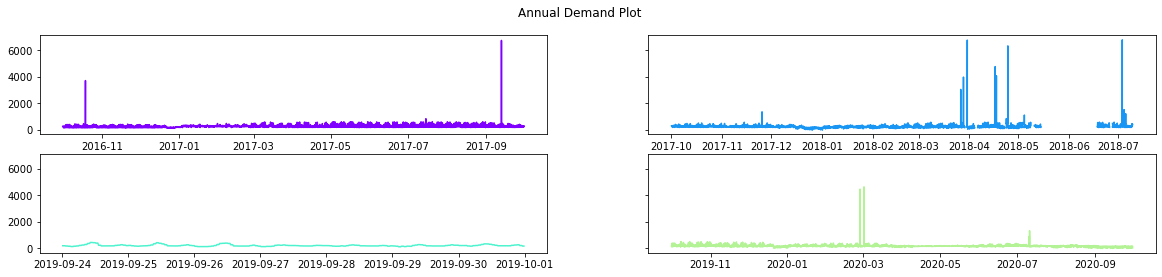

Date  Building0  Building1  Building3  Building4  Building5  \
0 2016-07-03 21:30:00      283.8        NaN      581.0        NaN        NaN   
1 2016-07-03 21:45:00      283.8        NaN      581.0        NaN        NaN   
2 2016-07-03 22:00:00      283.8        NaN      581.0        NaN        NaN   
3 2016-07-03 22:15:00      606.0        NaN      624.0        NaN        NaN   
4 2016-07-03 22:30:00      606.0        NaN      624.0        NaN        NaN   

   Building6  Solar0  Solar1  Solar2  Solar3  Solar4  Solar5  
0        NaN     NaN     NaN     NaN     NaN     NaN     NaN  
1        NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2        NaN     NaN     NaN     NaN     NaN     NaN     NaN  
3        NaN     NaN     NaN     NaN     NaN     NaN     NaN  
4        NaN     NaN     NaN     NaN     NaN     NaN     NaN

In [15]:
#create figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 4), sharey=True)
color=cm.rainbow(np.linspace(0,1,6))
years = ['2016', '2017', '2018', '2019', '2020']
i = 1
building_df = pd.DataFrame()
for ax, c in zip(axes.flatten(), color):
    #generate start and end dates
    start_date = years[i-1] + '-09-30 23:45:00'
    end_date = years[i] + '-09-30 23:45:00'
    mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
    ax.plot(demand_df.loc[mask]['Date'], demand_df.loc[mask]['Building0'], color=c)
    building_df['year'+str(i)] = copy.copy(demand_df.loc[mask]['Building0'].reset_index(drop=True))
    print("number of 15 min intervals in year "+str(i)+": "+str(len(demand_df.loc[mask]['Building0'])))
    i += 1
fig.suptitle("Annual Demand Plot")
plt.show()

start_date = '2016-09-30 23:45:00'
end_date = '2020-09-29 23:45:00' #decrease 1 day due to leap year
mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
demand_df.loc[mask, 'Building0'] = fill_missing(building_df)
demand_df.head()

In [16]:
# Hai's Smoothing Peaks Function
def smooth_like_butter(peaks, ar):
    '''
    Input in a list with all the indexes that have peaks and returns an array with all 
    the indexes being smoothed by taking the mean of the previous and the next value
    '''
    arr = copy.copy(ar)
    for peak in peaks:
        i = 1
        j = 1
        while arr[peak + i] == arr[peak]:
            i += 1
        while arr[peak - j] == arr[peak]:
            j += 1
        val = (arr[peak + i] + arr[peak - j]) / 2
        arr[peak - j:peak + i] = val
    return arr

# demand_df smoothing

# Find peaks and append to array
peaks, _ = find_peaks(demand_df['Building0'], height=700)
Building0_peaks = np.zeros(len(demand_df))
Building0_peaks[:] = np.NaN
for i in peaks:
    Building0_peaks[i] = demand_df['Building0'][i]

# save smoothed demand_df
demand_df['Building0'] = smooth_like_butter(peaks, demand_df['Building0'])
demand_df.to_csv("demand_smoothed_building0")

# Autoregressive Forecasting Setup 

In [17]:
# Auto Regressive Forecasting
# https://towardsdatascience.com/time-series-forecasting-with-autoregressive-processes-ba629717401

# imports
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

demand_df = pd.read_csv("demand_smoothed_building0", parse_dates=["Date"])

In [18]:
# Remove empty rows
demand_df["Building0"].replace("", np.nan, inplace=True) # replaces empty string
demand_df.dropna(subset=["Building0"], inplace=True) # removes nan rows

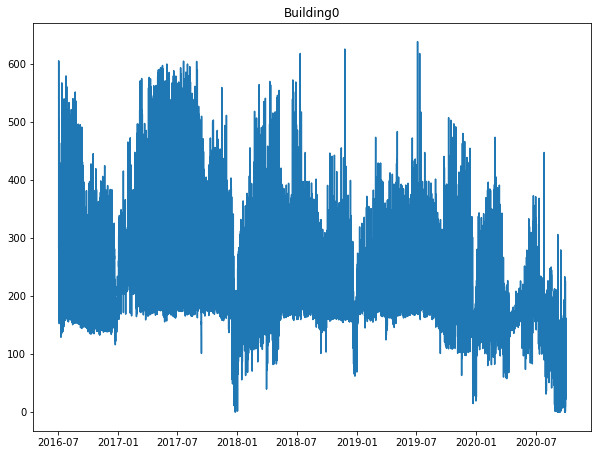

In [19]:
# Plot time series
plt.figure(figsize=[10, 7.5]); # Set dimensions for figure
plt.plot(demand_df["Date"], demand_df["Building0"])
plt.title("Building0")
plt.show()

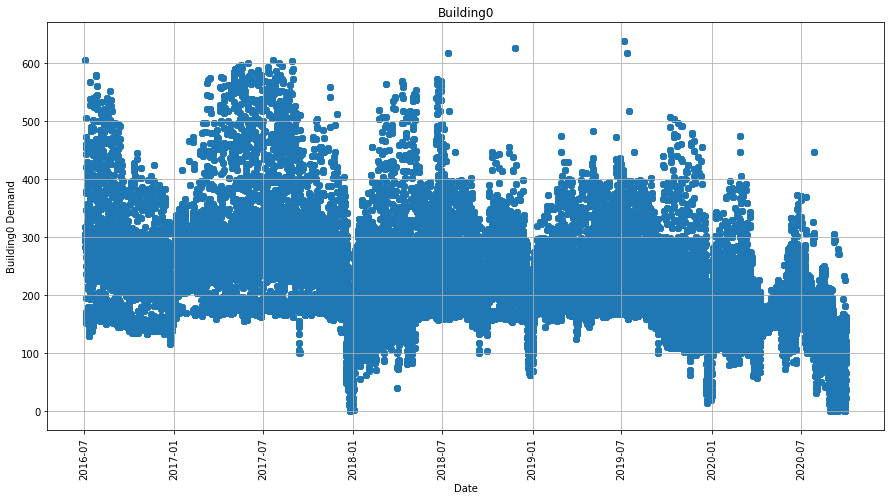

In [20]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.scatter(demand_df["Date"], demand_df["Building0"])
plt.title("Building0")
plt.ylabel("Building0 Demand")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [21]:
# AR(p) process requires stationary data, so let's take the log difference to make it stationary
demand_df["Building0"] = np.log(demand_df["Building0"])
demand_df["Building0"] = demand_df['Building0'].diff()
demand_df = demand_df.drop(demand_df.index[0])
demand_df

Unnamed: 0                Date  Building0  Building1  Building3  \
1                1 2016-07-03 21:45:00   0.000000        NaN      581.0   
2                2 2016-07-03 22:00:00   0.000000        NaN      581.0   
3                3 2016-07-03 22:15:00   0.758610        NaN      624.0   
4                4 2016-07-03 22:30:00   0.000000        NaN      624.0   
5                5 2016-07-03 22:45:00   0.000000        NaN      624.0   
...            ...                 ...        ...        ...        ...   
148805      148805 2020-09-30 22:45:00   0.000000       14.4      389.0   
148806      148806 2020-09-30 23:00:00   0.000000       18.8      389.0   
148807      148807 2020-09-30 23:15:00  -0.952009        4.5      415.0   
148808      148808 2020-09-30 23:30:00   0.000000        9.6      415.0   
148809      148809 2020-09-30 23:45:00   0.000000       14.0      415.0   

        Building4  Building5  Building6  Solar0  Solar1  Solar2  Solar3  \
1             NaN        NaN        NaN     NaN     NaN     NaN     NaN   
2             NaN        NaN        NaN     NaN     NaN     NaN     NaN   
3             NaN        NaN        NaN     NaN     NaN     NaN     NaN   
4             NaN        NaN        NaN     NaN     NaN     NaN     NaN   
5             NaN        NaN        NaN     NaN     NaN     NaN     NaN   
...           ...        ...        ...     ...     ...     ...     ...   
148805        NaN        NaN       35.6   29.67    6.68    6.34    5.49   
148806        1.0        NaN       38.6   29.94    6.71    6.39    5.65   
148807        NaN        NaN       38.6   34.02    8.13    7.71    6.83   
148808        NaN        NaN       38.6   38.10    9.55    9.03    8.02   
148809        NaN        NaN       38.6   39.88   10.12    9.67    8.62   

        Solar4  Solar5  
1          NaN     NaN  
2          NaN     NaN  
3          NaN     NaN  
4          NaN     NaN  
5          NaN     NaN  
...        ...     ...  
148805    4.55   25.28  
148806    4.57   25.30  
148807    5.32   28.62  
148808    6.08   31.94  
148809    6.33   32.92  

[148809 rows x 14 columns]

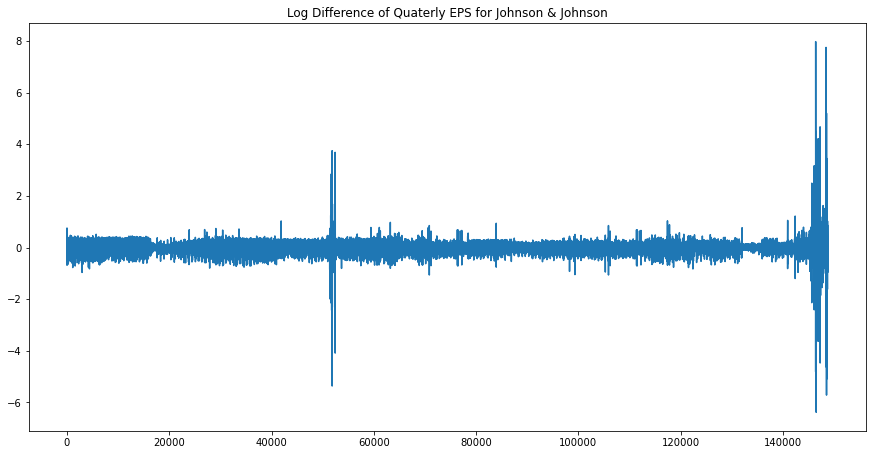

In [22]:
# Plot transformed time series
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(demand_df["Building0"])
plt.title("Log Difference of Quaterly EPS for Johnson & Johnson")
plt.show()

Now the data appears to have no trend, but to ensure how stationary the data is we can use the Dick-Fuller test for statistical significance.

In [23]:
ad_fuller_result = adfuller(demand_df["Building0"])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -100.13853121065557
p-value: 0.0


As we have a very large, negative ADF statistic and an extremely low p-value of 0 - we can reject the null hypothesis and say that our time series is stationary.

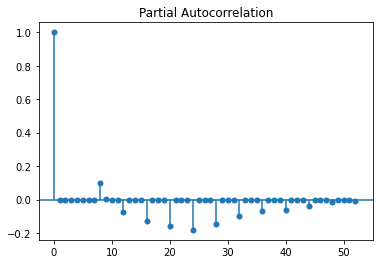

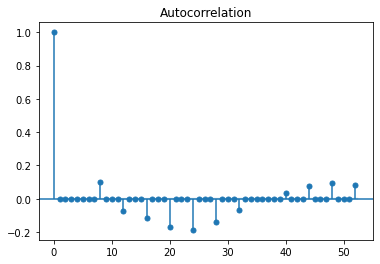

In [24]:
# Plot autocorrelation and partial autocorrelation plots
plot_pacf(demand_df["Building0"]);
plot_acf(demand_df["Building0"]);

Coefficients are least important after lag 1, now use a Yule-Walker equation to estimate of AR(p) of order 1

Other options include:

Coefficients are least important after lag 8, now use a Yule-Walker equation to estimate of AR(p) of order 8

Coefficients are least important after lag 33, now use a Yule-Walker equation to estimate of AR(p) of order 33

Coefficients are least important after lag 39, now use a Yule-Walker equation to estimate of AR(p) of order 39

Coefficients are least important after lag 43, now use a Yule-Walker equation to estimate of AR(p) of order 43

# Autoregressive Model of Order 1

In [26]:
# Try a AR(1) model
rho, sigma = yule_walker(demand_df["Building0"], 1)
print(f'rho: {-rho}')
print(f'sigma: {sigma}')

rho: [0.00166727]
sigma: 0.10147121133129801


Therefore, the function is best approximated for:

y_t = 0.10 + 1.67 * 10^-3 * y_t-1

# Autoregressive Model of Order 8

In [27]:
# Try a AR(8) model
rho, sigma = yule_walker(demand_df["Building0"], 8)
print(f'rho: {-rho}')
print(f'sigma: {sigma}')

rho: [ 0.00167907  0.0006772  -0.00028777  0.00012538 -0.00025718  0.0010094
 -0.00027881 -0.09888423]
sigma: 0.10097379363595169


Therefore, the function is best approximated for:

y_t = 0.10 + 1.67 * 10^-3 * y_t-1 + 6.77 * 10^-4 * y_t-2 -2.88 * 10^-4 * t_y-3 etc

# Autoregressive Model of Order 33

In [29]:
# Try a AR(33) model
rho, sigma = yule_walker(demand_df["Building0"], 33)
print(f'rho: {-rho}')
print(f'sigma: {sigma}')

rho: [ 2.42041661e-03  1.11944246e-03  3.07507261e-04  9.24039361e-02
  3.75089435e-04  1.53697715e-03  1.64142503e-04 -3.41621296e-02
 -7.53748396e-04  3.42703346e-04  2.03538727e-04  9.52866290e-02
  7.69168991e-04  1.00489892e-04  1.83757601e-04  1.29160787e-01
  1.37899947e-03  7.09741973e-04  2.88776572e-04  1.60638741e-01
  8.73344313e-04  4.54734830e-04  3.13673378e-04  1.83766979e-01
  4.56502632e-04  7.91135066e-04  5.77054052e-04  1.54697229e-01
  8.74384074e-04  9.71261742e-04  2.84885875e-04  9.82938994e-02
  5.53530335e-04]
sigma: 0.09545946186457019


# Autoregressive Model of Order 39

In [30]:
# Try a AR(39) model
rho, sigma = yule_walker(demand_df["Building0"], 39)
print(f'rho: {-rho}')
print(f'sigma: {sigma}')

rho: [ 0.0025039   0.0014014   0.0004805   0.09929443  0.0004279   0.00192251
  0.00043147 -0.02332019 -0.00067872  0.00079813  0.00049565  0.10816399
  0.00084233  0.00056433  0.00050553  0.14041779  0.00144931  0.00113282
  0.0006048   0.16969015  0.0009315   0.00076177  0.00053823  0.19044442
  0.00050781  0.00092633  0.00055578  0.15230661  0.00089248  0.00116815
  0.00038509  0.10477214  0.00060911  0.00136     0.00115887  0.07006466
  0.00022585  0.0012559   0.00057714]
sigma: 0.09522468514566461


# Autoregressive Model of Order 43

In [31]:
# Try a AR(43) model
rho, sigma = yule_walker(demand_df["Building0"], 44)
print(f'rho: {-rho}')
print(f'sigma: {sigma}')

rho: [ 0.0025902   0.00159207  0.00054201  0.1062684   0.00057299  0.00214881
  0.00051461 -0.01363466 -0.00055273  0.00104094  0.00061881  0.12193634
  0.00097736  0.00084701  0.00064047  0.15882216  0.0016147   0.00143913
  0.00076808  0.18835718  0.00109303  0.00106785  0.00074477  0.20650337
  0.00065081  0.00118099  0.00073288  0.16520889  0.00101033  0.00137676
  0.00042715  0.10793363  0.0006511   0.00150342  0.00115751  0.07573445
  0.00033156  0.00153881  0.00080004  0.06777523  0.00054348  0.00112961
  0.00049448  0.03941597]
sigma: 0.0949574753431957
